In [12]:
from stable_baselines3 import DQN, PPO
from utils import *
from data_logger import DataLogger
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
#Loading parameters
ep, lp, hp = get_params("mario") #params["environment"], params["logging"], params["hyperparameters"]
hp_algo = hp['ppo']

In [14]:
#Environment
env = get_env(game=ep["game"], level=ep["level"], action_space=ep["action_space"])
env = apply_wrappers(env, skip=ep["skip"], gray_scale=ep["gray_scale"], shape=ep["frame_shape"], num_stack=ep["num_stack"])
next_state = env.reset()
print(next_state.shape)

(4, 84, 84)


{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 48, 'y_pos': 121}


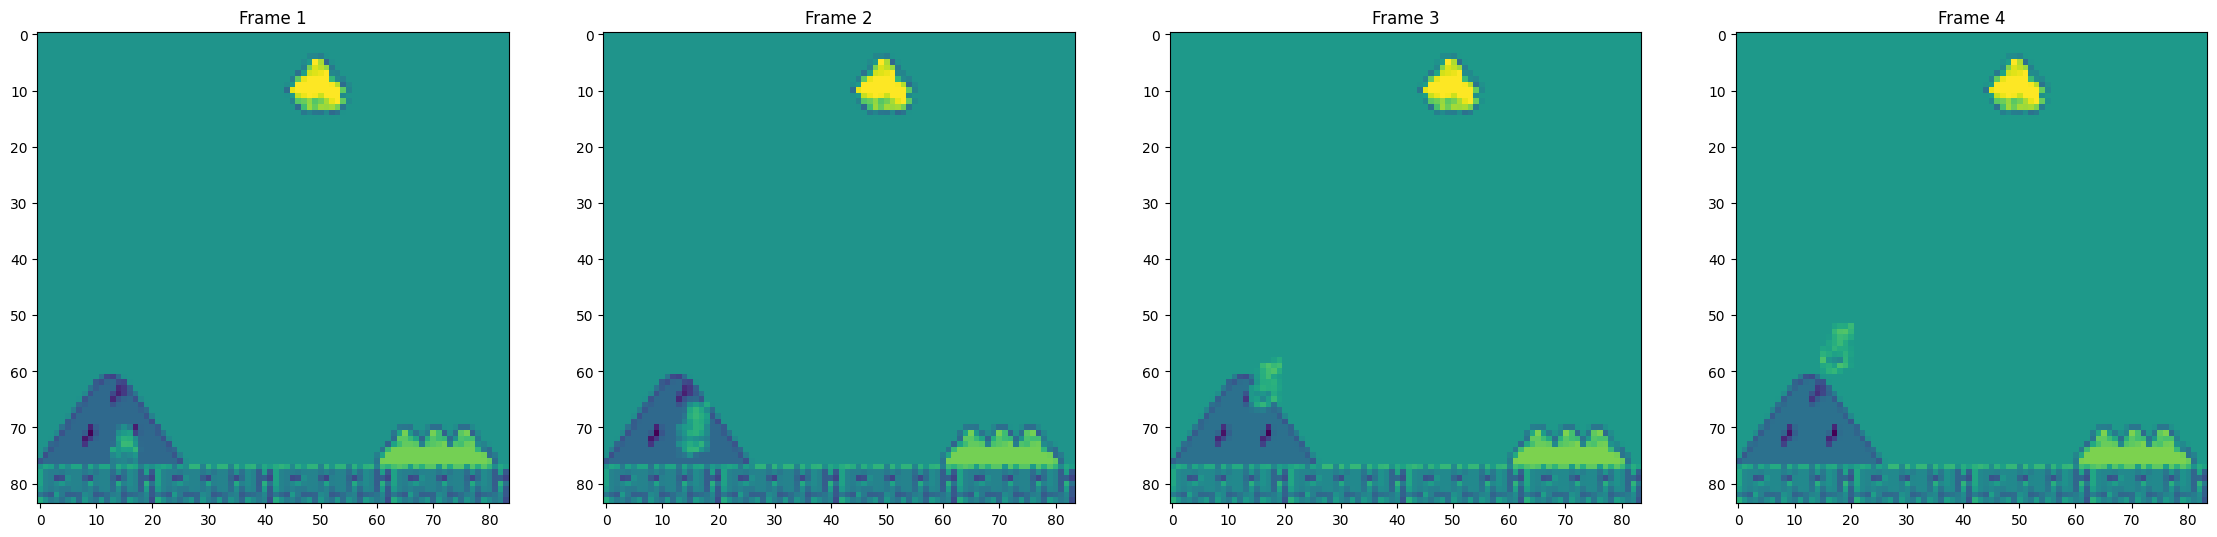

In [18]:
from utils import *
next_state, reward, done, info = env.step(get_action_sample(env))
plot_sequence_observations(next_state)
print(info)

In [7]:
#Logging
from stable_baselines3.common.callbacks import BaseCallback
import collections

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting winrate in tensorboard and saving hyperparameters.
    """
    def __init__(self, verbose=0, game="mario"):
        super().__init__(verbose)
        self.reward_history = []
        self.win_rate_history = []
        self.episodes_prev_act = collections.deque([0, 0], maxlen=2)
        self.win_prev_act = collections.deque([0, 0], maxlen=2)
        self.game = game
        self.episode_num = 0

    def _on_step(self) -> bool:
        self.episodes_prev_act.append(self.episode_num)

        if self.game=="mario":
            if self.locals["dones"][0] or self.locals["infos"][0]["flag_get"]:
                self.episode_num += 1
            self.win_prev_act.append(int(self.locals["infos"][0]["flag_get"]))
        elif self.game=="sonic":
            if self.locals["dones"][0]:
                self.episode_num += 1
            self.win_prev_act.append(int(self.locals["dones"][0] and (self.locals["infos"][0]["prev_progress"])))
        
        if self.episodes_prev_act[0] != self.episodes_prev_act[1]:
            self.logger.record("rollout/winrate", self.win_prev_act[0])
            self.win_rate_history.append(self.win_prev_act[0])        
            self.reward_history.append(self.model.ep_info_buffer[-1]["r"])        
        return True   

logger = DataLogger(env, hp, model=hp_algo["model"])
checkpoint_callback = CheckpointCallback(save_freq=lp["n_time_steps_save_model"], save_path=logger.folder_path_models, name_prefix="chkpt")#saving the model periodically
eval_callback = EvalCallback(env, best_model_save_path=logger.folder_path_models, log_path=logger.folder_path_models, eval_freq=lp["evaluate_best_model_every"], deterministic=True, render=False)#evaluating the model periodically and saving the best one
log_callback = TensorboardCallback(game = ep["game"])

In [6]:
#Hyperparams DQN
# model = DQN("CnnPolicy",
#             env,
#             double_dqn = (hp_algo["model"]=="DDQN"), 
#             buffer_size = hp_algo["buffer_size"],
#             batch_size = hp_algo["batch_size"],
#             learning_starts = hp_algo["learning_starts"],
#             learning_rate = hp_algo["learning_rate"],
#             gamma = hp_algo["discount_factor"],  
#             exploration_fraction = hp_algo["exploration_fraction"],
#             exploration_final_eps = hp_algo["exploration_final_eps"],
#             train_freq = hp_algo["train_freq"],                    
#             target_update_interval = hp_algo["target_update_interval"],   
#             tensorboard_log = logger.folder_path_train,
#             verbose = 1,
#             device = device
#             )

In [7]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=logger.folder_path_train, learning_rate=hp_algo["learning_rate"])

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(hp_algo["time_steps"],
            callback=[log_callback, checkpoint_callback, eval_callback],
            tb_log_name="second_training_learning_rate_1e-4")

logger.total_rewards = log_callback.reward_history
logger.wins = log_callback.win_rate_history
logger.close()

In [3]:
import time
# Load the trained model
model = DQN.load(r"logs/SonicTheHedgehog-Genesis/DDQN/20240202033654/checkpoints/chkpt_525000_steps.zip")


env = get_env(game=ep["game"], level=ep["level"], action_space=ep["action_space"])
env = apply_wrappers(env, skip=ep["skip"], gray_scale=ep["gray_scale"], shape=ep["frame_shape"], num_stack=ep["num_stack"])# Test the model

while True:
    obs = env.reset()
    done = False
    while not done:
        action, _ = model.predict(np.array(obs))
        #print(action)
        obs, _, done, _ = env.step(int(action))
        env.render()
        time.sleep(0.01)

KeyboardInterrupt: 

: 

In [4]:
#Restart training
model_path = r"logs\SuperMarioBros-1-1-v0\PPO\20240205004950\checkpoints\chkpt_2000000_steps.zip"
log_path = r"logs\SuperMarioBros-1-1-v0\PPO\20240205004950\train"
model = PPO.load(model_path, tensorboard_log=log_path)
model.set_env(env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [10]:
model.learn(hp_algo["time_steps"],
            callback=[log_callback, checkpoint_callback, eval_callback],
            reset_num_timesteps=False)

Logging to logs\SuperMarioBros-1-1-v0\PPO\20240205004950\train\PPO_0


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 212      |
|    ep_rew_mean     | 1.71e+03 |
|    winrate         | 0        |
| time/              |          |
|    fps             | 75       |
|    iterations      | 1        |
|    time_elapsed    | 27       |
|    total_timesteps | 3236     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 256         |
|    ep_rew_mean          | 1.81e+03    |
|    winrate              | 0           |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 2           |
|    time_elapsed         | 58          |
|    total_timesteps      | 5284        |
| train/                  |             |
|    approx_kl            | 0.011418074 |
|    clip_fraction        | 0.0627      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0993   

e:\10mociclo\Applied\RL_Sonic-TheHedgehog\venv38\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=25000, episode_reward=1325.00 +/- 0.00
Episode length: 149.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 149        |
|    mean_reward          | 1.32e+03   |
| rollout/                |            |
|    winrate              | 0          |
| time/                   |            |
|    total_timesteps      | 25000      |
| train/                  |            |
|    approx_kl            | 0.04283315 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.408     |
|    explained_variance   | 0.994      |
|    learning_rate        | 3e-05      |
|    loss                 | 4.41       |
|    n_updates            | 9870       |
|    policy_gradient_loss | 0.00692    |
|    value_loss           | 30.3       |
----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |


KeyboardInterrupt: 